Step 1: Load and Explore Data

In [49]:
import pandas as pd

# Load training and test datasets
train_data = pd.read_csv('training.csv')
test_data = pd.read_csv('test.csv')

# Display basic information about the dataset
print(train_data.info())
print(train_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

In [50]:
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48707 entries, 0 to 48706
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              48707 non-null  int64  
 1   PurchDate                          48707 non-null  object 
 2   Auction                            48707 non-null  object 
 3   VehYear                            48707 non-null  int64  
 4   VehicleAge                         48707 non-null  int64  
 5   Make                               48707 non-null  object 
 6   Model                              48707 non-null  object 
 7   Trim                               47157 non-null  object 
 8   SubModel                           48702 non-null  object 
 9   Color                              48703 non-null  object 
 10  Transmission                       48704 non-null  object 
 11  WheelTypeID                        46519 non-null  flo

Step 2: Preprocess Data

We will be using a transformation pipeline for numeric features, it is using StandardScaler. This will standardize numeric features by removing the mean and scaling to unit variance. This is done to each column independently.

For categorical features, we will be using OneHotEncoder so that the variables are in a format that can be provided to machine learning algorithms to improve predictions.

ColumnTransformer will let us apply different transformers to different subsets of columns in the dataset.

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Separate features and target variable
X_train = train_data.drop('IsBadBuy', axis=1)
y_train = train_data['IsBadBuy']
X_test = test_data.copy()

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Create transformers for numeric and categorical features with missing values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label_encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


Making sure that there are no more null values in the data

In [46]:
# Get column names after transformation for numeric features
numeric_column_names = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numeric_features)

# Get column names after transformation for categorical features
categorical_column_names = preprocessor.named_transformers_['cat'].named_steps['label_encoder'].get_feature_names_out(categorical_features)

# Combine numeric and categorical column names
column_names = list(numeric_column_names) + list(categorical_column_names)

# Assuming X_train_preprocessed and X_test_preprocessed are CSR matrices
# Convert them to dense arrays for DataFrame creation
X_train_dense = X_train_preprocessed.toarray()
X_test_dense = X_test_preprocessed.toarray()

# Create DataFrames from dense arrays
X_train_df = pd.DataFrame(X_train_dense, columns=column_names)
X_test_df = pd.DataFrame(X_test_dense, columns=column_names)

# Check for null values in DataFrames
null_values_train = X_train_df.isnull().sum()
null_values_test = X_test_df.isnull().sum()

# Display null values (if any)
print("Null values in X_train_df:\n", null_values_train[null_values_train > 0])
print("\nNull values in X_test_df:\n", null_values_test[null_values_test > 0])


Null values in X_train_df:
 Series([], dtype: int64)

Null values in X_test_df:
 Series([], dtype: int64)


In [47]:
# Display null values in the original data
print("Null values in original X_train:\n", X_train[numeric_features_with_missing + categorical_features_with_missing].isnull().sum())
print("\nNull values in original X_test:\n", X_test[numeric_features_with_missing + categorical_features_with_missing].isnull().sum())


Null values in original X_train:
 Trim                                 2360
SubModel                                8
Color                                   8
Transmission                            9
WheelTypeID                          3169
WheelType                            3174
Nationality                             5
Size                                    5
TopThreeAmericanName                    5
MMRAcquisitionAuctionAveragePrice      18
MMRAcquisitionAuctionCleanPrice        18
MMRAcquisitionRetailAveragePrice       18
MMRAcquisitonRetailCleanPrice          18
MMRCurrentAuctionAveragePrice         315
MMRCurrentAuctionCleanPrice           315
MMRCurrentRetailAveragePrice          315
MMRCurrentRetailCleanPrice            315
dtype: int64

Null values in original X_test:
 Trim                                 1550
SubModel                                5
Color                                   4
Transmission                            3
WheelTypeID                          

Step 3: Train Model with Hyperparameter Tuning (GridSearchCV)

We are using Random Forest Classifier first.

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
model = RandomForestClassifier()

# Define the hyperparameter grid including the step name (classifier) and parameter names
param_grid = {
    'classifier__n_estimators': [3, 5, 50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    # Add other hyperparameters as needed
}

# Create a pipeline with the classifier
pipeline = Pipeline(steps=[('classifier', model)])

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train_preprocessed, y_train)

# Print the best hyperparameters from GridSearch
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END classifier__max_depth=None, classifier__n_estimators=3; total time=   5.6s
[CV] END classifier__max_depth=None, classifier__n_estimators=3; total time=   4.1s
[CV] END classifier__max_depth=None, classifier__n_estimators=3; total time=   4.6s
[CV] END classifier__max_depth=None, classifier__n_estimators=5; total time=   7.6s
[CV] END classifier__max_depth=None, classifier__n_estimators=5; total time=   8.4s
[CV] END classifier__max_depth=None, classifier__n_estimators=5; total time=   7.8s
[CV] END classifier__max_depth=None, classifier__n_estimators=50; total time= 1.5min
[CV] END classifier__max_depth=None, classifier__n_estimators=50; total time= 1.5min
[CV] END classifier__max_depth=None, classifier__n_estimators=50; total time= 1.4min
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time= 2.0min
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time= 1.2min
[CV] END

In [56]:
import pandas as pd

cv_results_df = pd.DataFrame(grid_search.cv_results_)
print(cv_results_df)


    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        4.843588      0.639118         0.031351        0.000123   
1        7.963760      0.325686         0.053711        0.009066   
2       85.661826      2.752732         0.469638        0.077222   
3       89.238012     23.283532         0.434072        0.066275   
4      152.942030      3.751135         0.883935        0.166072   
5        0.167715      0.007852         0.014665        0.003813   
6        0.271380      0.009362         0.015626        0.000004   
7        2.377040      0.032913         0.078487        0.000180   
8        4.808732      0.169596         0.150586        0.008543   
9        9.728061      0.346206         0.297781        0.000019   
10       0.489674      0.016862         0.018359        0.003745   
11       0.724660      0.026276         0.015629        0.000110   
12       6.972114      0.282698         0.099175        0.007330   
13      14.010819      0.808717         0.198978

Mean accuracy of the best parameters was 87.7739%
It's std test score was 0.000677 which is considered really low. This indicates stable performance.

Using SHAP to find the least important variables, that will be removed.
We will then run the model again and see if it gets better with the least important variables.

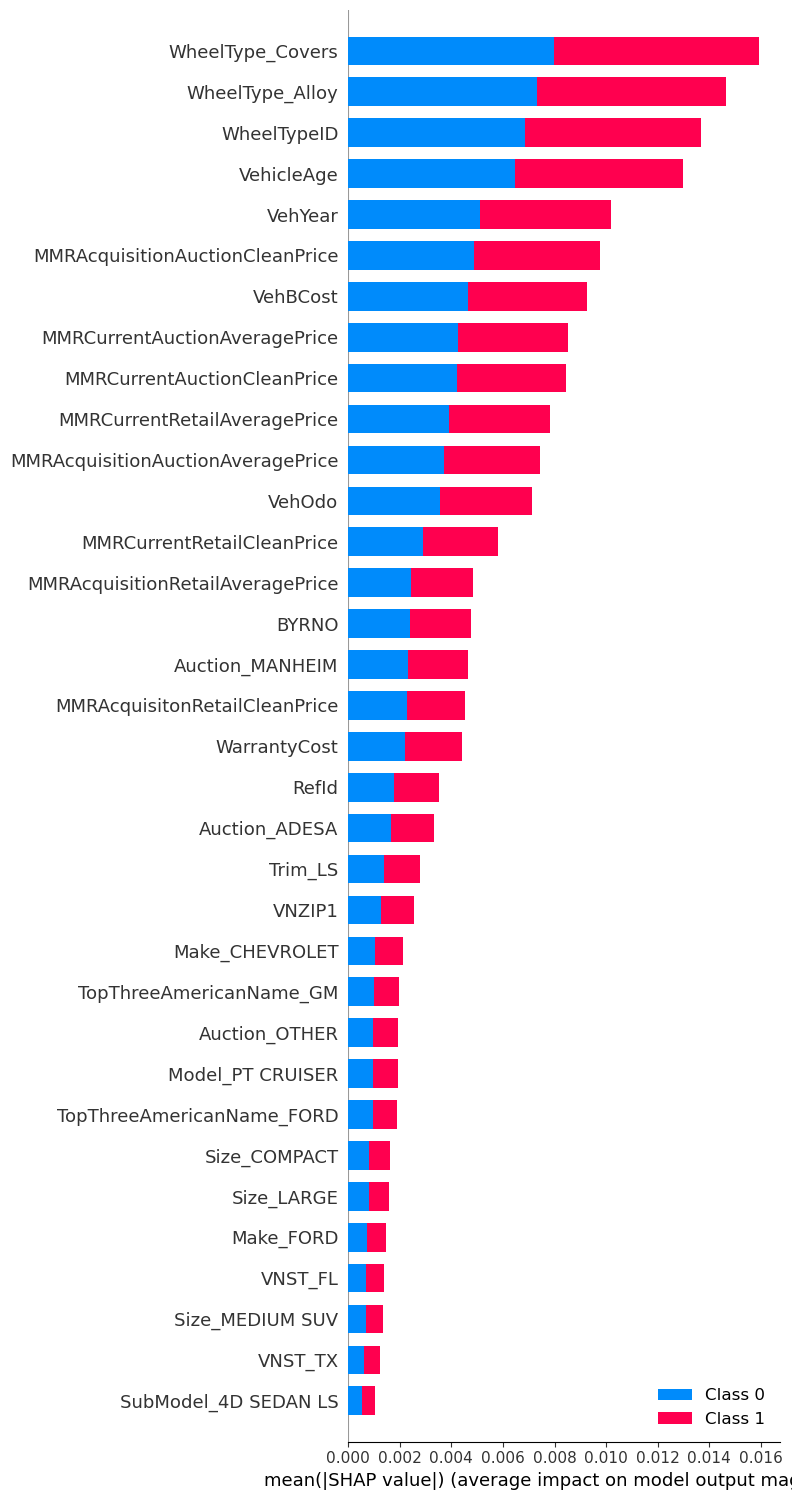

 28%|██▊       | 20421/72983 [50:31<2:11:55,  6.64it/s]

In [ ]:
import shap
from tqdm import tqdm

best_model = grid_search.best_estimator_

# Extract the RandomForestClassifier from the pipeline
random_forest = best_model.named_steps['classifier']

# Create a SHAP explainer for the RandomForestClassifier
explainer = shap.TreeExplainer(random_forest)

# Transform the preprocessed training data to a numpy array
X_train_numpy = X_train_preprocessed.toarray()  # Assuming X_train_preprocessed is a sparse matrix

# Calculate SHAP values with aggregation
shap_values = explainer.shap_values(X_train_numpy, approximate=True, check_additivity=False)
# Assuming preprocessor is your ColumnTransformer
preprocessor.fit(X_train)

# Get the transformed feature names from the column transformer
feature_names = preprocessor.named_transformers_['cat'] \
                    .named_steps['label_encoder'] \
                    .get_feature_names_out(categorical_features)

# Combine numeric and categorical feature names
all_feature_names = numeric_features.tolist() + feature_names.tolist()

# Summary plot of feature importance
shap.summary_plot(shap_values, X_train_preprocessed, feature_names=all_feature_names, max_display=34)

# If you want to show a progress bar, you can wrap your loop with tqdm
for i in tqdm(range(len(X_train_numpy))):
    _ = explainer.shap_values(X_train_numpy[i, :])


IndexError: index 535 is out of bounds for axis 0 with size 33

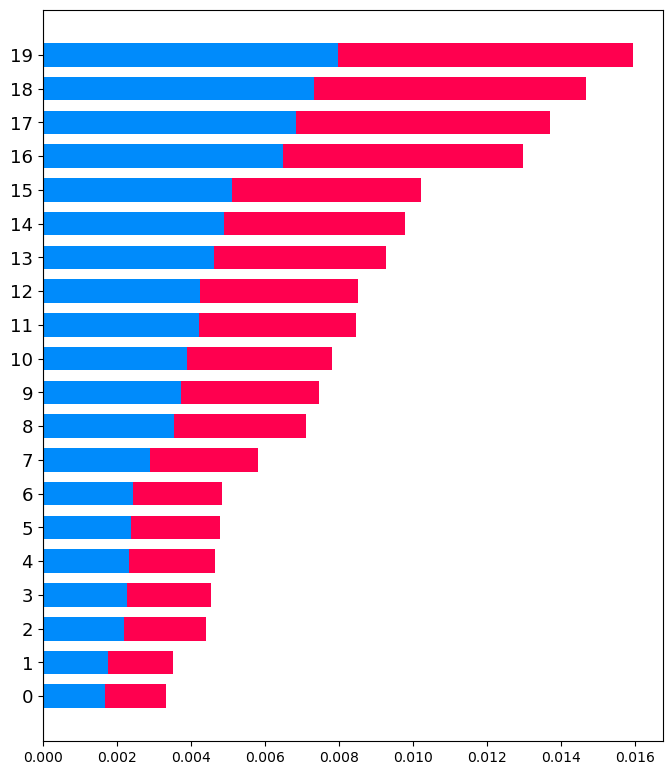

In [62]:
import shap

best_model = grid_search.best_estimator_

# Extract the RandomForestClassifier from the pipeline
random_forest = best_model.named_steps['classifier']

# Create a SHAP explainer for the RandomForestClassifier
explainer = shap.TreeExplainer(random_forest)

# Transform the preprocessed training data to a numpy array
X_train_numpy = X_train_preprocessed.toarray()  # Assuming X_train_preprocessed is a sparse matrix

# Calculate SHAP values with aggregation
shap_values = explainer.shap_values(X_train_numpy, approximate=True)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_train_preprocessed, feature_names=X_train.columns)


In [3]:
X_train_preprocessed.shape

NameError: name 'X_train_preprocessed' is not defined